In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import json
import numpy as np
from collections import defaultdict


In [176]:
independent_vars = ['dataset', 'join', 'operator', 'num_cores']

# Read all files and add variable for run to analyze dev after
def load(path='../profile1/*/*'):
    dfs = []
    for f in glob(path):
        df = pd.read_json(f, lines=True)
        df = df.assign(**pd.json_normalize(df.profiled))
        df = df[~df.full_output.apply(lambda x: 'File' in x)].reset_index(drop=True)
        df.drop(columns=['profiled'
            , 'full_output'
             ], inplace=True)
        convert_from_string_to_numeric_cols = ['cache-misses', 'cache-references', 'fpu_pipe_assignment.total']
        df[convert_from_string_to_numeric_cols] = df[convert_from_string_to_numeric_cols].apply(pd.to_numeric)
        df['run'] = int(f.split('\\')[-2][4:])
        dfs.append(df)

    df = pd.concat(dfs)
    # Subtract mean of baseline cache-misses and references for each set of independent vars
    baseline_means = defaultdict(lambda: {})

    for metric in ['cache-misses', 'cache-references']:
        for group, dfgroup in df[df.operator == 'Noop'].groupby(['dataset', 'join', 'num_cores']):
            baseline_means[metric][group] = dfgroup[metric].mean()

    def subtract_mean(row: pd.Series):
        return  row[-1] - baseline_means[row.index[-1]][tuple(row[:-1])]

    df['cache_miss'] = df[['dataset', 'join', 'num_cores', 'cache-misses']].apply(subtract_mean,axis=1)
    df['cache_ref'] = df[['dataset', 'join', 'num_cores', 'cache-references']].apply(subtract_mean,axis=1)
    df['cache_misses_pct'] = df['cache_miss'] / df['cache_ref']

    return df

results_df = load()
results_df.columns

Index(['dataset', 'join', 'operator', 'tuple_ratio', 'feature_ratio',
       'cardinality_T', 'cardinality_S', 'selectivity', 'time_baseline',
       'time_amalur', 'num_cores', 'baseline_std', 'baseline_mean',
       'amalur_std', 'amalur_mean', 'cache-misses', 'cache-references',
       'fpu_pipe_assignment.total', 'run', 'cache_miss', 'cache_ref',
       'cache_misses_pct'],
      dtype='object')

In [146]:
results_df[(results_df.scache_miss < 0) & (results_df.operator != 'Noop')]

,dataset,join,operator,tuple_ratio,feature_ratio,cardinality_T,cardinality_S,selectivity,time_baseline,time_amalur,...,baseline_mean,amalur_std,amalur_mean,cache-misses,cache-references,fpu_pipe_assignment.total,run,cache_miss,cache_ref,cache_misses_pct
1,book,inner,Left multiply,0.557832,1.914246,253120,77848,0.307554,"[0.001973925998754, 0.0014132229989620001, 0.0...","[0.0007365229976130001, 0.0006182199977040001,...",...,0.001258,0.000125,0.000282,41911525,429446236,108007201,1,-1609400.2,47681996.4,-0.033753
7,book,inner,Left multiply T,0.557832,1.914246,253120,77848,0.307554,"[0.001555651000671, 0.09418677900248401, 0.001...","[0.001210332000482, 0.0006802669995520001, 0.0...",...,0.004386,0.000189,0.000346,41500648,417915810,63149523,1,-2020277.2,36151570.4,-0.055884
1,book,inner,Left multiply,0.557832,1.914246,253120,77848,0.307554,"[0.0016045559968910002, 0.06950765399960801, 0...","[0.0007855660005580001, 0.0006628049959540001,...",...,0.005931,0.000126,0.000320,39876601,445204798,104428532,1,-1353789.2,53704373.8,-0.025208
1,book,inner,Left multiply,0.557832,1.914246,253120,77848,0.307554,"[0.0015000079947640002, 0.001412675999745, 0.0...","[0.000619565995293, 0.000506114003655, 0.00043...",...,0.001247,0.000076,0.000351,39468433,480202905,152684497,1,-1079768.6,60212040.2,-0.017933
7,book,inner,Left multiply T,0.557832,1.914246,253120,77848,0.307554,"[0.001585099002113, 0.001502585000707, 0.00143...","[0.0008836190027060001, 0.0007691759965380001,...",...,0.001657,0.000135,0.000405,39832269,494488880,129005674,1,-715932.6,74498015.2,-0.009610
14,book,outer,Left multiply,0.557832,1.914246,253120,62279,0.246045,"[0.001354621002974, 0.001175336001324, 0.00112...","[0.0008461999968850001, 0.0006739889940940001,...",...,0.001005,0.000132,0.000334,38600289,442225493,101930434,1,-161789.8,33497320.6,-0.004830
1,book,inner,Left multiply,0.557832,1.914246,253120,77848,0.307554,"[0.001685395000095, 0.0015850659983690002, 0.0...","[0.0006927709982840001, 0.0005816530028820001,...",...,0.001331,0.000084,0.000350,38887594,500820806,155434120,1,-2508682.2,60760929.6,-0.041288
7,book,inner,Left multiply T,0.557832,1.914246,253120,77848,0.307554,"[0.0020445190020830003, 0.0018669059936650002,...","[0.000930888003495, 0.000719450996257, 0.00062...",...,0.001565,0.000137,0.000406,40770211,467840405,99804328,1,-626065.2,27780528.6,-0.022536
79,flight,outer,Left multiply,10.657912,682.450000,66548,72792,1.093827,"[0.001355382002657, 0.00094021300174, 0.000762...","[0.000651611997454, 0.000452378000773, 0.00043...",...,0.000713,0.000060,0.000373,36653188,425969458,105564784,1,-173315.0,-38332636.0,0.004521
85,flight,outer,Left multiply T,10.657912,682.450000,66548,72792,1.093827,"[0.0012703929969570002, 0.001023269003781, 0.0...","[0.000734977998945, 0.00047658299445100003, 0....",...,0.000845,0.000072,0.000393,36342105,437905063,136310691,1,-484398.0,-26397031.0,0.018350


# Is the variance of the profiling metrics acceptable
### Compare metric values between runs
Compute mean and std of each metric for each combination of variables (dataset, join, operator, num_cores)

In [155]:
metric_var_df = results_df.melt(id_vars=['dataset', 'join', 'operator', 'num_cores'], value_vars=['cache-misses', 'cache-references', 'fpu_pipe_assignment.total'])
print("Check if for each experiment there is the same amount of rows")
display(metric_var_df.groupby(['dataset', 'join', 'operator', 'num_cores']).count().variable.apply(lambda x: x != 12).value_counts())
# sns.catplot(metric_var_df, x='variable', y='value', hue='num_cores', col='dataset', row='join')
mean_df = metric_var_df.groupby(['dataset', 'join', 'operator', 'num_cores', 'variable']).agg(_mean=('value', np.mean), _std=('value', np.std), _vals=('value', lambda x: x.values.tolist()), _count=('value', np.count_nonzero))
mean_df

Check if for each experiment there is the same amount of rows


True    1170
Name: variable, dtype: int64

_mean  \
dataset join  operator         num_cores variable                                 
book    inner Column summation 4         cache-misses                51698880.8   
                                         cache-references           474230763.0   
                                         fpu_pipe_assignment.total  157908768.4   
                               8         cache-misses                51916303.2   
                                         cache-references           481050646.6   
...                                                                         ...   
yelp    union Row summation T  32        cache-references           783718974.2   
                                         fpu_pipe_assignment.total  641596032.8   
                               64        cache-misses                69375293.4   
                                         cache-references           803314098.8   
                                         fpu_pipe_assignment.total  718733874.6   

                                                                            _std  \
dataset join  operator         num_cores variable                                  
book    inner Column summation 4         cache-misses               9.767138e+05   
                                         cache-references           4.630823e+06   
                                         fpu_pipe_assignment.total  2.390817e+06   
                               8         cache-misses               1.370027e+06   
                                         cache-references           7.392048e+06   
...                                                                          ...   
yelp    union Row summation T  32        cache-references           1.635271e+07   
                                         fpu_pipe_assignment.total  3.178616e+07   
                               64        cache-misses               2.461434e+06   
                                         cache-references           4.319170e+07   
                                         fpu_pipe_assignment.total  1.141486e+07   

                                                                                                                _vals  \
dataset join  operator         num_cores variable                                                                       
book    inner Column summation 4         cache-misses               [51270157, 52847537, 51333745, 50492794, 52550...   
                                         cache-references           [480451137, 471878465, 471403032, 469647678, 4...   
                                         fpu_pipe_assignment.total  [161425520, 158601716, 158112403, 155358532, 1...   
                               8         cache-misses               [51861739, 51008567, 52214817, 50463327, 54033...   
                                         cache-references           [468988375, 485269012, 481871168, 480693276, 4...   
...                                                                                                               ...   
yelp    union Row summation T  32        cache-references           [774140527, 799031872, 765995082, 776345755, 8...   
                                         fpu_pipe_assignment.total  [648612389, 618411428, 694252613, 626203981, 6...   
                               64        cache-misses               [69867519, 66836220, 69411115, 73166668, 67594...   
                                         cache-references           [765728685, 850937562, 774850704, 849953514, 7...   
                                         fpu_pipe_assignment.total  [710356048, 716218155, 710362060, 738088056, 7...   

                                                                    _count  
dataset join  operator         num_cores variable                           
book    inner Column summation 4         cache-misses                    5  
                                         cache-references                5  
                   

Text(0.5, 0.98, 'Distribution of normalized variance for each profiling metric')

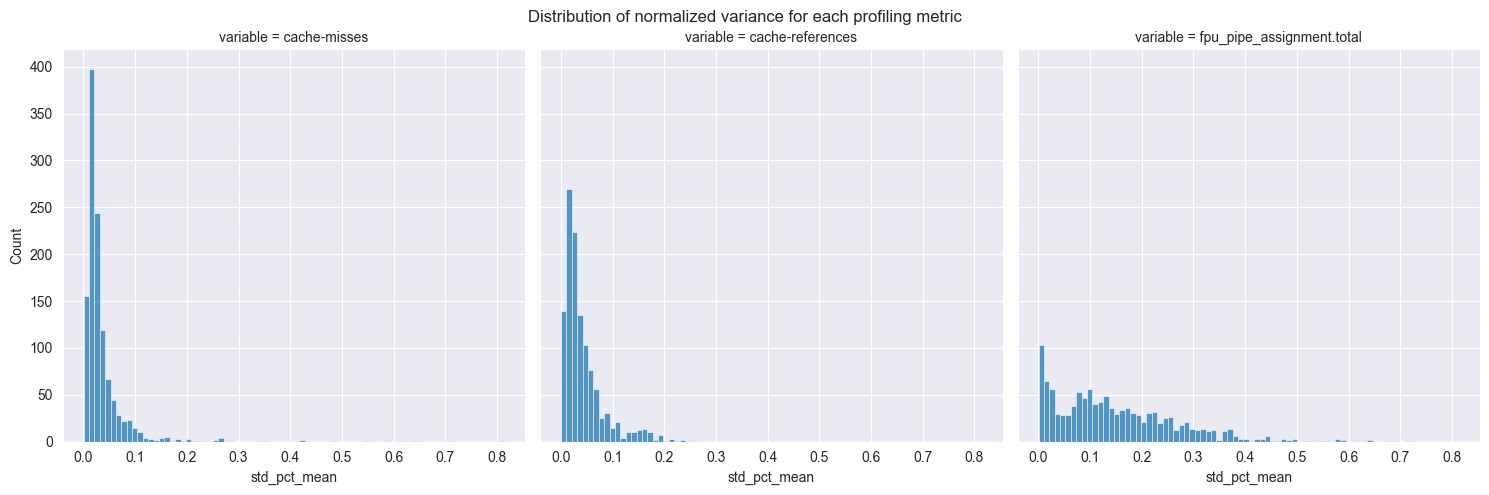

In [161]:
mean_df['std_pct_mean'] = (mean_df._std / mean_df._mean)
plot = sns.displot(data=mean_df, x='std_pct_mean', col='variable')
plot.fig.subplots_adjust(top=0.9)
plot.fig.suptitle("Distribution of normalized variance for each profiling metric")

In [148]:
mean_df[mean_df.std_pct_mean > 10].groupby('variable')._mean.count()

Series([], Name: _mean, dtype: int64)

# Simple overview of percentage of cache misses
Per operator

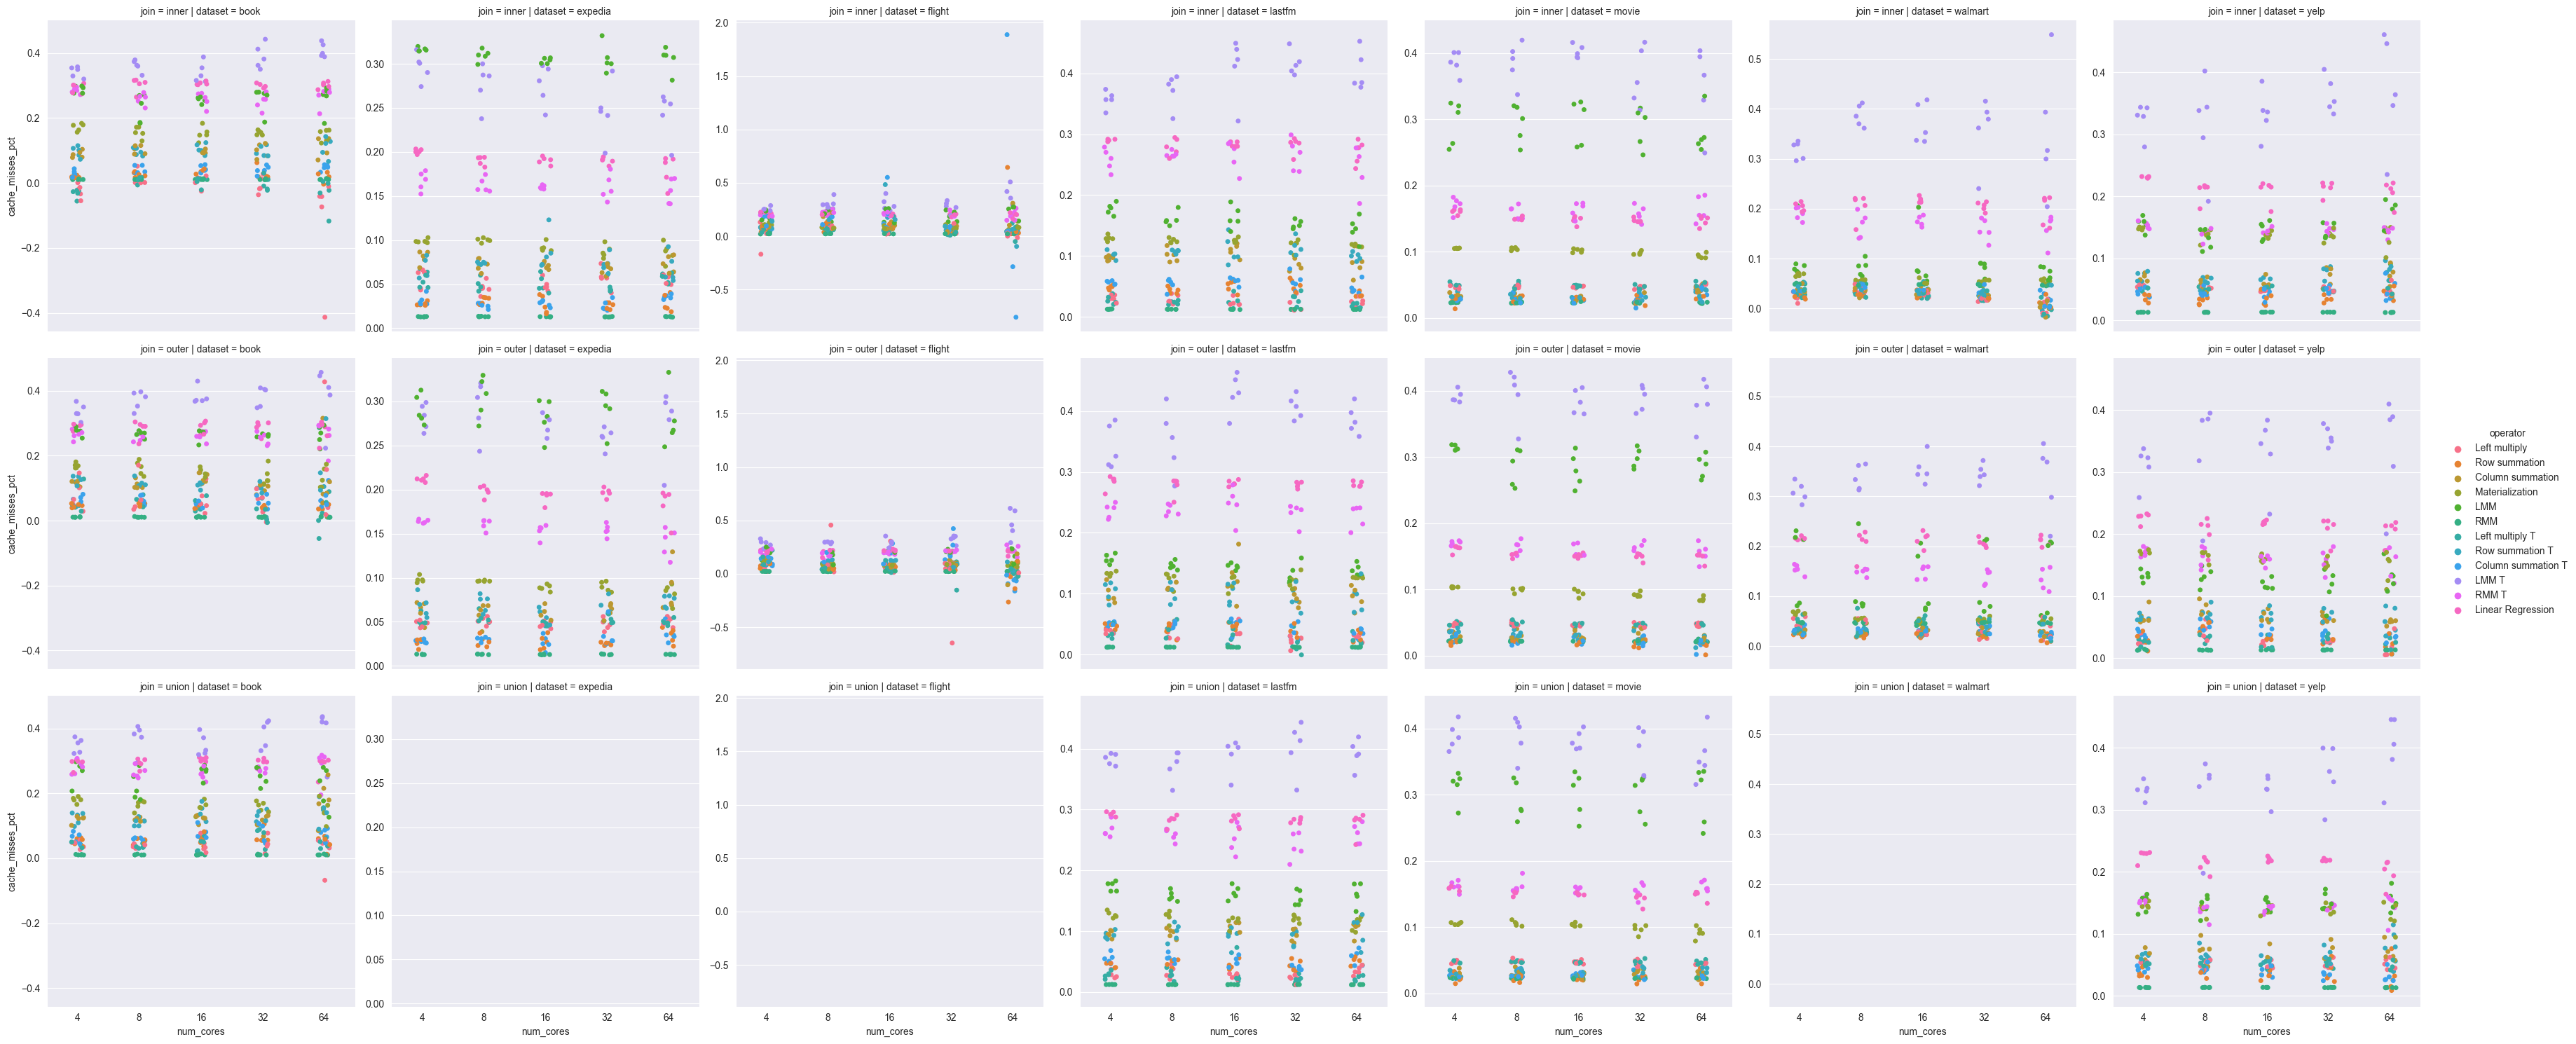

In [162]:
fig = sns.catplot(data=results_df[results_df.operator != 'Noop'], x='num_cores', y='cache_misses_pct', hue='operator', col='dataset', row='join', sharey='col')

In [163]:
fig.savefig('tmp.pdf')

C:\Users\ptema\AppData\Local\Temp\ipykernel_24296\2605029449.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(results_df.corr()[['cache_misses_pct']], annot=True)


<Axes: >

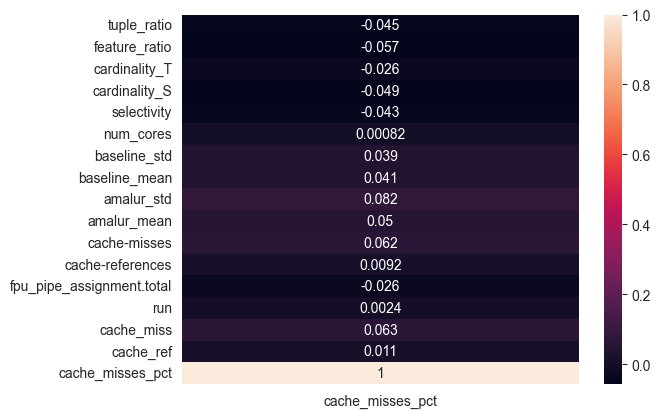

In [150]:
sns.heatmap(results_df.corr()[['cache_misses_pct']], annot=True)

C:\Users\ptema\AppData\Local\Temp\ipykernel_24296\35413349.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.scatterplot(results_df[(results_df['join'] == 'outer') & (results_df.dataset== 'yelp') & (results_df.num_cores == 16)].groupby([ 'operator', 'num_cores']).mean()[[


(0.0, 0.1)

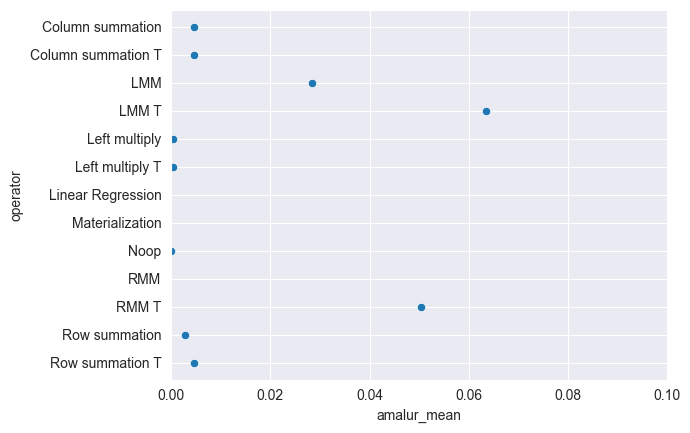

In [175]:
fig, ax=plt.subplots()

sns.scatterplot(results_df[(results_df['join'] == 'outer') & (results_df.dataset== 'yelp') & (results_df.num_cores == 16)].groupby([ 'operator', 'num_cores']).mean()[[
    'amalur_mean', 'amalur_std', 'baseline_std', 'baseline_mean'
]], y='operator', x='amalur_mean', ax=ax)
ax.set_xlim([0,0.1])

In [ ]:
results_df[(results_df['join'] == 'outer') & (results_df.dataset== 'yelp') & (results_df.num_cores == 16)].groupby([ 'operator', 'num_cores']).mean()[[
    'amalur_mean', 'amalur_std', 'baseline_std', 'baseline_mean'
]]

# Profiling metrics for No Operation


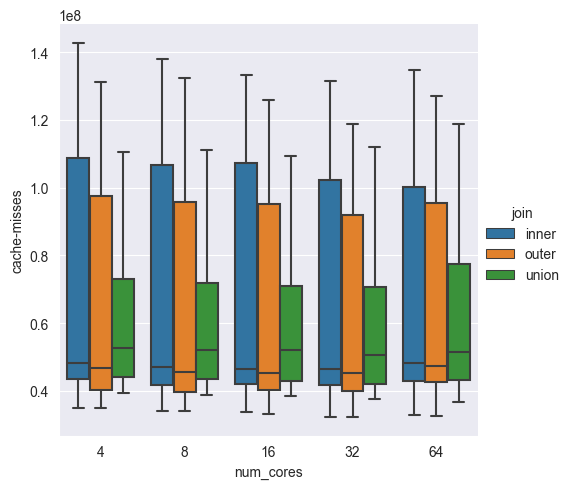

In [151]:
sns.catplot(data=results_df[results_df.operator=='Noop'], x='num_cores', y='cache-misses',
            hue='join',
            # col='num_cores',
            kind='box'
            )

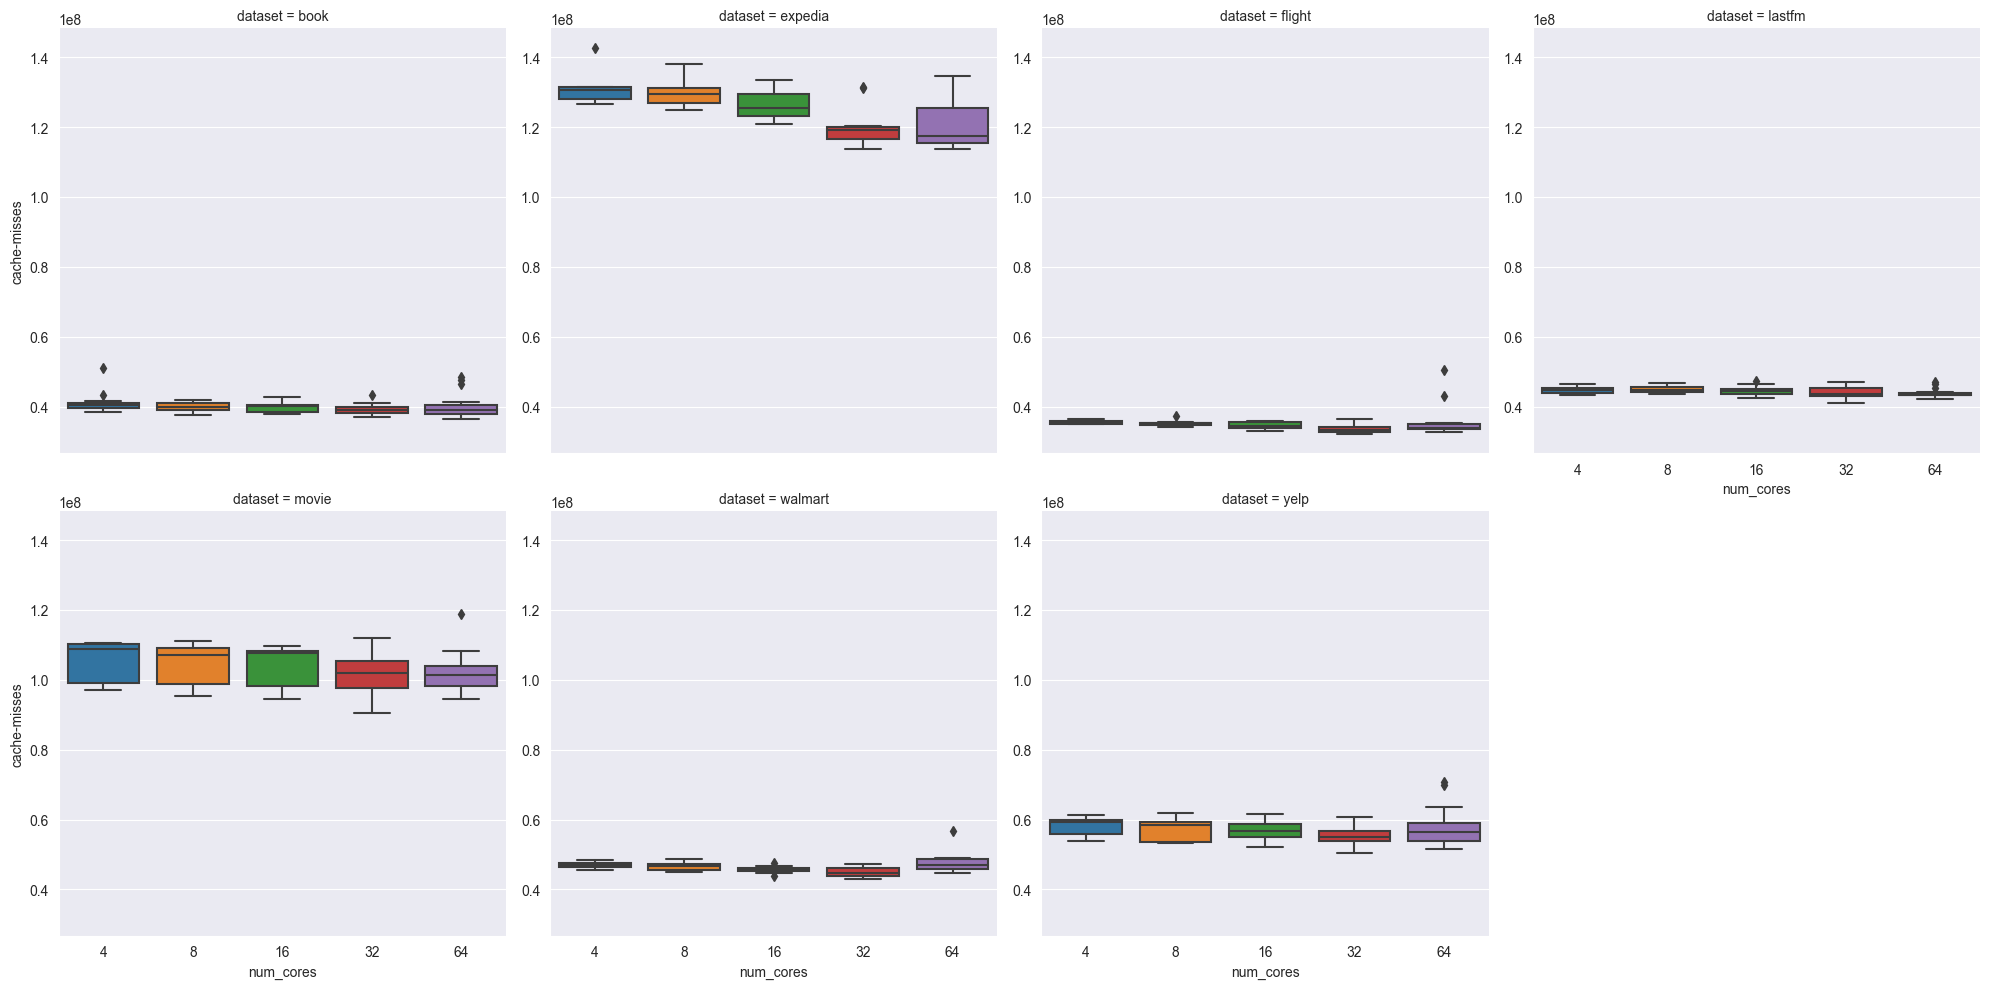

In [152]:
sns.catplot(data=results_df[results_df.operator=='Noop'], x='num_cores', y='cache-misses',
            # hue='num_cores',
            col='dataset',
            kind='box',
            sharey='col',
            col_wrap=4
            )